### 📦 Import Required Libraries

Import core packages for graph creation (NetworkX), linear algebra (NumPy, SciPy), and visualization (Matplotlib).


In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh  # for all eigenvalues
from scipy.sparse.linalg import eigsh  # for top-k eigenvalues of sparse symmetric matrices
import time

In [11]:
def matmul_naive(A, B):
    n = A.shape[0]
    C = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                C[i, j] += A[i, k] * B[k, j]
    return C

def trace_A3(matmul_fn, A): #let's use the naive multiplication here 
    A2 = matmul_fn(A, A)
    A3 = matmul_fn(A2, A)
    return np.trace(A3) 

### 🧠 Eigentriangle Approximation Function

Defines a function to estimate the number of triangles using the spectral method:

$$T_k = \frac{1}{6} \sum_{i=1}^k \lambda_i^3$$ 

using the top-$k$ eigenvalues of the adjacency matrix $A$. This approximation was introduced by in

> Charalampos Tsourakakis. *Fast counting of triangles in large real networks without counting: Algorithms and laws*. ICDM 2008.  

This method is useful for large-scale graphs where exact triangle counting is computationally expensive and empirically few eigenvalues suffice to provide a good approximation.


In [2]:
def eigentriangle_estimate(A, k):
    start = time.time()
    eigenvals = eigsh(A, k=k, which='LM', return_eigenvectors=False)
    triangle_est = (1/6) * np.sum(eigenvals**3)
    t_est = time.time() - start
    return triangle_est, t_est

### 🔍 Find Minimum Rank $k$ to Achieve Target Relative Error

This function searches for the smallest $k$ such that the Eigentriangle estimate is within a user-defined relative error threshold compared to the exact triangle count.


In [3]:
def find_min_k_for_error(A, exact_triangle_count, eps_percent, k_max=None):
    """
    Find the smallest k such that the Eigentriangle estimate has relative error < eps_percent.
    
    Parameters:
        A: Sparse adjacency matrix (scipy.sparse)
        exact_triangle_count: int, ground truth triangle count
        eps_percent: float, error threshold in percent (e.g., 5 for 5%)
        k_max: int, upper limit on k to prevent infinite loop
        
    Returns:
        k: smallest integer satisfying the condition
        estimate: corresponding Eigentriangle estimate
        rel_error: relative error (%)
    """
    if k_max is None:
        k_max = A.shape[0]

    for k in range(1, k_max + 1):
        est, _ = eigentriangle_estimate(A, k)
        rel_error = abs(est - exact_triangle_count) / exact_triangle_count * 100
        if rel_error < eps_percent:
            return k, est, rel_error
        else:
            print(f"for rank {k} the relative error is {rel_error} since the exact count is {exact_triangle_count} and the estimate {est}")
    return None, None, None  # No such k found within k_max


### 🎯 Run Eigentriangle Approximation on Erdős–Rényi Graph

Create a random Erdős–Rényi graph and compute:
- Exact triangle count
- Eigentriangle approximations for several values of $k$
- Relative errors compared to the ground truth

In [4]:
n = 5000
p = 0.1
G = nx.erdos_renyi_graph(n, p)
A = nx.to_scipy_sparse_array(G, format='csr', dtype=float)

start = time.time()
exact_triangle_count = sum(nx.triangles(G).values()) // 3
t_exact = time.time() - start
print(f"Exact count: {exact_triangle_count} (Time: {t_exact:.4f} s)")

est, t_est = eigentriangle_estimate(A, 1)
print(f"Eigentriangle estimate: {est} (Time: {t_est:.4f} s)")


Exact count: 20828180 (Time: 8.8016 s)
Eigentriangle estimate: 20944491.80707615 (Time: 0.0741 s)


In [5]:
rel_error = 100*abs(est - exact_triangle_count) / exact_triangle_count
print(f"Relative error of 1-rank approximation: {rel_error:.2f}%")

Relative error of 1-rank approximation: 0.56%


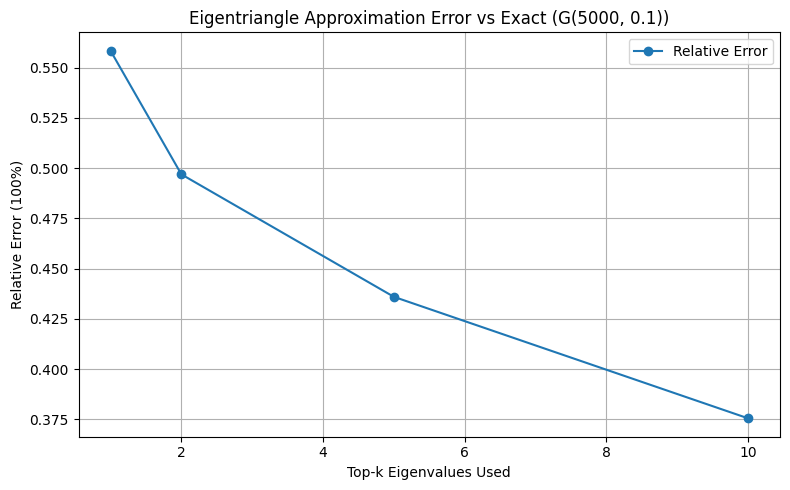

In [6]:
ks = [1, 2, 5, 10]
estimates_with_time = [eigentriangle_estimate(A, k) for k in ks]
estimates = [est for est, _ in estimates_with_time]
relative_errors = [100*abs(est - exact_triangle_count) / exact_triangle_count for est in estimates]



plt.figure(figsize=(8, 5))
plt.plot(ks, relative_errors, marker='o', label='Relative Error')
plt.xlabel('Top-k Eigenvalues Used')
plt.ylabel('Relative Error (100%)')
plt.title(f'Eigentriangle Approximation Error vs Exact (G({n}, {p}))')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 🧮 Histogram of Eigenvalues of the Adjacency Matrix

Visualize the spectral distribution (eigenvalues) of the adjacency matrix of the Erdős–Rényi graph to understand the contribution of different eigenvalues.


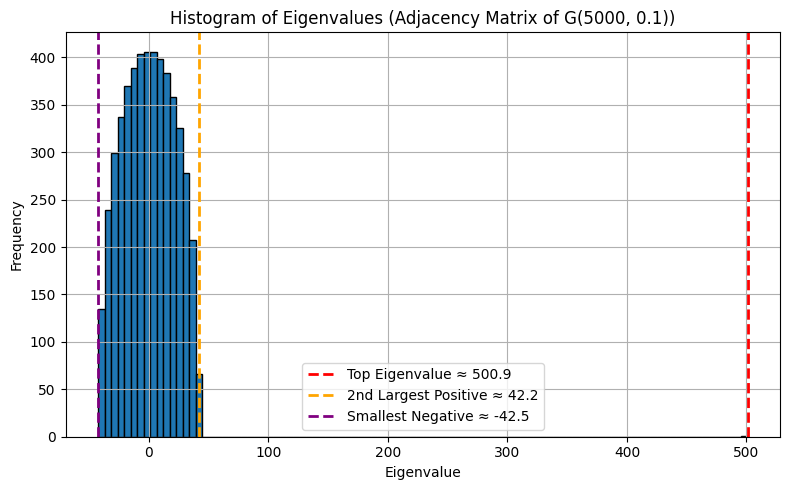

In [7]:

A_dense = nx.to_numpy_array(G, dtype=float)
eigenvals_all = eigh(A_dense, eigvals_only=True)
sorted_eigs = sorted(eigenvals_all, reverse=True)

# Extract key eigenvalues
top_eig = sorted_eigs[0]
second_pos_eig = next(e for e in sorted_eigs[1:] if e > 0)
min_neg_eig = min(eigenvals_all)

# Plot
plt.figure(figsize=(8, 5))
plt.hist(eigenvals_all, bins=100, edgecolor='black')
plt.axvline(top_eig, color='red', linestyle='--', linewidth=2, label=f'Top Eigenvalue ≈ {top_eig:.1f}')
plt.axvline(second_pos_eig, color='orange', linestyle='--', linewidth=2, label=f'2nd Largest Positive ≈ {second_pos_eig:.1f}')
plt.axvline(min_neg_eig, color='purple', linestyle='--', linewidth=2, label=f'Smallest Negative ≈ {min_neg_eig:.1f}')
plt.title(f'Histogram of Eigenvalues (Adjacency Matrix of G({n}, {p}))')
plt.xlabel('Eigenvalue')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
k_gnp = find_min_k_for_error(A, exact_triangle_count, 1)
print(f"smallest rank for which we get at most 1 per cent relative error {k_gnp[0]}")

smallest rank for which we get at most 1 per cent relative error 1


### 🌐 Eigentriangle on Small Toy Social Networks: Karate and Southern Women

Use the `karate_club_graph` and `davis_southern_women_graph` from NetworkX. For the latter, we project it onto women-only nodes, and repeat the Eigentriangle approximation to evaluate spectral accuracy in real social network data.


In [9]:
G_karate = nx.karate_club_graph()
A_karate = nx.to_numpy_array(G_karate, weight=None)
karate_triangle_count = sum(nx.triangles(G_karate).values()) // 3
k_karate = find_min_k_for_error(A_karate, karate_triangle_count, 1, None)
print(f"Smallest rank for ≤1% relative error: k = {k_karate[0]} | estimate = {k_karate[1]:.2f} | rel. error = {k_karate[2]:.2f}%")


for rank 1 the relative error is 12.68037164877266 since the exact count is 45 and the estimate 50.706167241947696
for rank 2 the relative error is 58.342756577936484 since the exact count is 45 and the estimate 71.25424046007141
for rank 3 the relative error is 24.879285013297682 since the exact count is 45 and the estimate 56.19567825598396
for rank 4 the relative error is 9.697830171609606 since the exact count is 45 and the estimate 49.36402357722432
for rank 5 the relative error is 1.450422902092833 since the exact count is 45 and the estimate 44.347309694058225
for rank 6 the relative error is 7.737665676842924 since the exact count is 45 and the estimate 48.481949554579316
for rank 7 the relative error is 2.374395032855906 since the exact count is 45 and the estimate 46.06847776478516
for rank 8 the relative error is 6.934317943231716 since the exact count is 45 and the estimate 48.12044307445427
for rank 9 the relative error is 3.5490892420397637 since the exact count is 45 and

In [10]:
G_bipartite = nx.davis_southern_women_graph()
women_nodes = [n for n, d in G_bipartite.nodes(data=True) if d["bipartite"] == 0]
G_women = nx.bipartite.projected_graph(G_bipartite, women_nodes)
A_women = nx.to_numpy_array(G_women, weight=None)
triangle_count = sum(nx.triangles(G_women).values()) // 3
k_result = find_min_k_for_error(A_women, triangle_count, eps_percent=1, k_max=len(A_women))
print(f"Smallest rank for ≤1% relative error: k = {k_result[0]} | estimate = {k_result[1]:.2f} | rel. error = {k_result[2]:.2f}%")

for rank 1 the relative error is 1.075400658835269 since the exact count is 631 and the estimate 637.7857781572505
Smallest rank for ≤1% relative error: k = 2 | estimate = 633.47 | rel. error = 0.39%


### 📚 References 

- **Eigentriangle Estimator**:  
  This notebook implements the spectral triangle estimation method introduced by  
  **Charalambos Tsourakakis** in:  
  > Tsourakakis, H. (2008). *Fast counting of triangles in large real networks without counting: Algorithms and laws*. ICDM 2008.  
  > [https://dl.acm.org/doi/10.1109/ICDM.2008.72](https://dl.acm.org/doi/10.1109/ICDM.2008.72)

- **Linear Algebra Foundations**:  
  Concepts involving eigenvalues, matrix powers, and trace identities draw from:  
  > **Gilbert Strang**, *Introduction to Linear Algebra*, 5th Edition (2016), Wellesley-Cambridge Press.
